# Classificação de Texto
<img src="https://github.com/gomesluiz/commonlit-readability-predicting/blob/main/images/banner_w_border.png?raw=true"
        alt="Banner do projeto"
        width="1020"
        height="300"
        style="display: block; margin: 0 auto" />
<br/>
A legibilidade mede a facilidade com que um leitor pode compreender e assimilar um conteúdo escrito. Essa medida está relacionada à fluidez da leitura e à capacidade do leitor em processar e entender as informações apresentadas. Um texto de alta legibilidade é fácil de ler, compreender e reter, enquanto um texto de baixa legibilidade é mais difícil de ser assimilado.
<br/><br/>
O objetivo deste notebook é mostrar o processo de criação de um modelo de classificação de legibilidade de um texto baseado em técnicas de Aprendizado de Máquina (AM) e de Processamento de Linguagem Natural (PLN). Tal modelo poderá ser utilizado para indicar o texto mais apropriado conforme o perfil do leitor e, assim, ajudar a motivar o hábito de leitura.
<br/><br/>


## Pacotes Python


In [1]:
# instalação dos pacotes necessários
!pip install nltk==3.8.1
!pip install scikit-learn==1.2.2
!pip install wordcloud==1.9.3
!pip install unidecode==1.3.8
!pip install seaborn==0.13.1
!pip install pandas==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.3 MB/s eta 0:00:00


In [2]:
# Importações da biblioteca padrão
import datetime
import math
import pickle
import re
import string
import sys
import warnings

# Importações de bibliotecas de terceiros
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from unidecode import unidecode
from wordcloud import WordCloud

# Downloads do NLTK
nltk.download('punkt')
nltk.download("stopwords")

# Configurações e comandos específicos (por exemplo, desativar avisos)
warnings.filterwarnings('ignore')

print("Pacotes importados com sucesso; notebook pronto para uso!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...


Pacotes importados com sucesso; notebook pronto para uso!


[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Declara define funções utilitárias utilizadas no notebook.
def formata_msg(nivel, msg):
    """
    Formata uma mensagem de log incluindo o nível de severidade, timestamp
    e a mensagem.

    Parâmetros:
    - nivel (str): Nível de severidade da mensagem (ex: 'INFO', 'ERROR', 'WARNING').
    - msg (str): A mensagem de log propriamente dita.

    Retorna:
    - str: A mensagem de log formatada.
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    return f"[{nivel}] {timestamp} - {msg}"

def preprocessa_texto(texto):
    """
    Preprocessa o texto fornecido realizando várias etapas de limpeza.

    Etapas:
    1. Tokeniza o texto.
    2. Converte os tokens para minúsculos.
    3. Remove stopwords em português.
    4. Remove números dos tokens.
    5. Exclui tokens que são pontuações.
    6. Remove acentuações dos tokens.

    Parâmetros:
    texto (str): O texto a ser preprocessado.

    Retorna:
    list: Lista de tokens preprocessados.
    """

    # Tokeniza o texto usando um padrão para capturar palavras e pontuações.
    padrao = r"\w+(?:'\w+)?|[^\w\s]"
    tokens_preprocessados = re.findall(padrao, texto)

    # Converte os tokens para minúsculos para padronizar a capitalização.
    tokens_preprocessados = [token.lower() for token in tokens_preprocessados]

    # Remove stopwords para reduzir o conjunto de tokens a palavras significativas.
    portugues_stops = stopwords.words('english')
    tokens_preprocessados = [token for token in tokens_preprocessados if token not in portugues_stops]

    # Remove números, pois geralmente não contribuem para o significado do texto.
    tokens_preprocessados = [re.sub(r'\d+', '', token) for token in tokens_preprocessados if re.sub(r'\d+', '', token)]

    # Exclui tokens que são pontuações, pois raramente são úteis para análise de texto.
    tokens_preprocessados = [token for token in tokens_preprocessados if token not in string.punctuation]

    # Remove acentuações para padronizar os tokens.
    tokens_preprocessados = [unidecode(token) for token in tokens_preprocessados]

    return ' '.join(tokens_preprocessados)

print(formata_msg("INFO", "Funções utilitárias prontas para utilização."))
print(formata_msg("INFO", f"Versão do Python: {sys.version} "))

[INFO] 2024-05-05 22:10:36 - Funções utilitárias prontas para utilização.
[INFO] 2024-05-05 22:10:36 - Versão do Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 


## Metodologia
A metodologia deste projeto está divida nas etapas do processo padrão de mineração de dados denominado Cross Industry Process for Data Mining (CRISP-DM). O modelo CRISP-DM define um conjunto comum de etapas, tarefas e entregáveis necessários para a realização bem-sucedida de um projeto de mineração de dados. Esse modelo é composto por seis etapas principais:
<br/><br/>
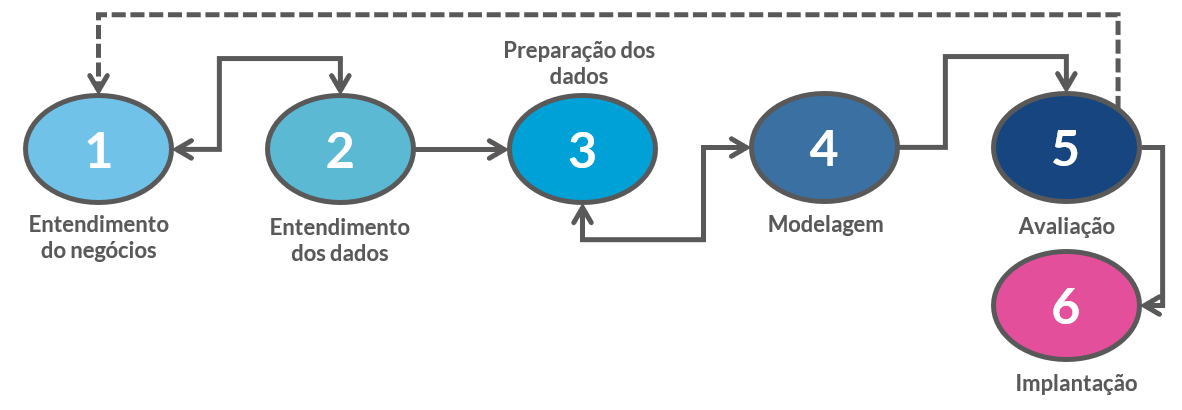

## 1. Entendimento do negócio
Nessa etapa, é necessário entender o problema abordado e as questões relacionadas ele. No contexto deste projeto, a questão primária a ser respondida é

> Por meio das técnicas de Aprendizado de Máquina (AM) e Processamento de Linguagem Natural (PLN), é possível predizer a legibilidade de um texto com uma alta precisão?


## 2. Entendimento dos dados

Nesta etapa, é necessário avaliar os dados disponíveis ou se é necessário coletar dados para responder às perguntas levantadas na etapa de **entendimento do negócio**.
<br/><br/>
O modelo de predição será desenvolvido a partir de uma base de dados utilizada na competição [CommonLit Readability Prize](https://www.kaggle.com/competitions/commonlitreadabilityprize) promovida pela Kaggle  e patrocinada pela empresa [CommonLit, Inc.](https://www.commonlit.org/en); e pelo [Departamento de Linguística da Georgia State University](https://alsl.gsu.edu/).
<br/><br/>
**Descrição da base de dados**

* **id**: Identificador para trecho do texto.
* **url_legal**: URL da fonte do trecho do texto.
* **license**: Licença de uso do trecho do texto.
* **excerpt**: Trecho do texto avaliado.
* **target**: legibilidade do trecho do texto.
* **standard_error**: medida da dispersão das pontuações entre múltiplos avaliadores para cada trecho. Não inclui dados de testes.


### 2.1 Coleta de dados




In [4]:
# URL para download dos dados de treinamento.
URL_PATH = (
    "https://raw.githubusercontent.com/gomesluiz/"
    "commonlit-readability-predicting/main/datasets/train.csv"
)

# Leitura das colunas 'excerpt' e 'target' do arquivo CSV.
trechos = pd.read_csv(URL_PATH, usecols=["excerpt", "target"])

# Renomeia as colunas para 'trecho' e 'legibilidade'.
trechos.columns = ["trecho", "legibilidade"]
print(formata_msg("INFO", f"Estatística da coluna legibilidade:\n{trechos['legibilidade'].describe()}"))


[INFO] 2024-05-05 22:10:37 - Estatística da coluna legibilidade:
count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: legibilidade, dtype: float64


In [5]:
# Categoriza a coluna 'legibilidade' com base em intervalos de valores.
legibilidade_categoria=["Muito Dificil", "Dificil", "Moderadamente Dificil", "Padrão", "Bastante Facil", "Facil"]
trechos["legibilidade_categoria"] = pd.cut(
    trechos["legibilidade"],
    bins=[-4.00, -3.00, -2.00, -1.00, 0.00, 1.00, 2.00],
    labels=legibilidade_categoria,
)

# Exibe os dez primeiros registros do DataFrame.
trechos.head(10)

,trecho,legibilidade,legibilidade_categoria
0,When the young people returned to the ballroom...,-0.340259,Padrão
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão
3,And outside before the palace a great garden w...,-1.054013,Moderadamente Dificil
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil
5,Hal and Chester found ample time to take an in...,-0.861809,Padrão
6,Hal Paine and Chester Crawford were typical Am...,-1.759061,Moderadamente Dificil
7,"On the twenty-second of February, 1916, an aut...",-0.952325,Padrão
8,The boys left the capitol and made their way d...,-0.371641,Padrão
9,One day he had gone beyond any point which he ...,-1.238432,Moderadamente Dificil


## 2.2 Análise exploratória de dados

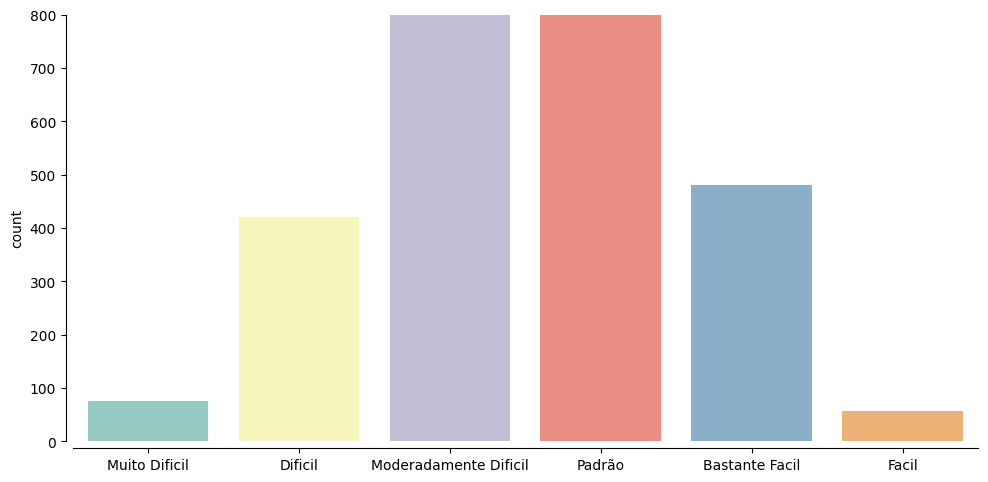

In [6]:
g=sns.catplot(data=trechos
              , x="legibilidade_categoria"
              , height=5
              , aspect=2
              , kind="count"
              , palette="Set3"
              , legend=False)
sns.despine(offset=5)

g.set(ylim=(0, 800))
g.set(xlabel=None)

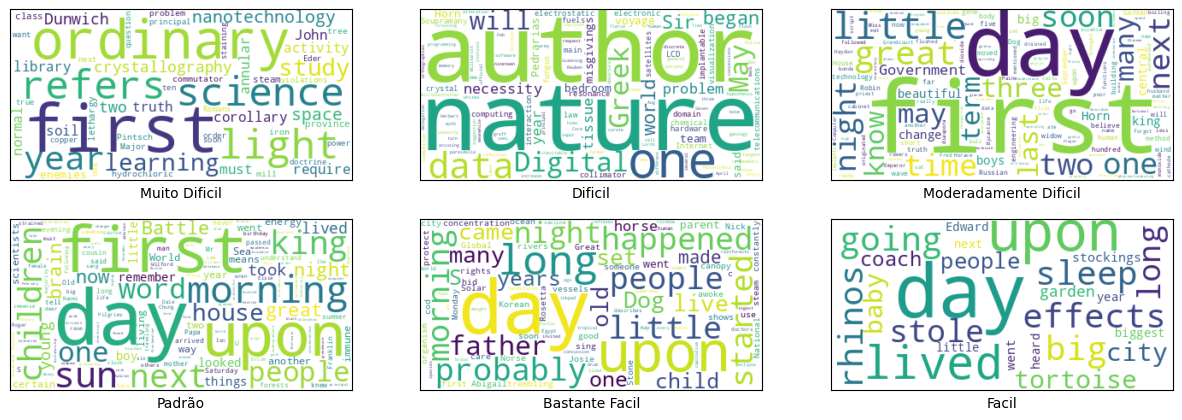

In [7]:
linhas, colunas = 2, 3
conta_linha, conta_coluna = 0, 0
fig, ax = plt.subplots(linhas, colunas, sharex='col', sharey='row', figsize=(15, 5))


for categoria in legibilidade_categoria:
  textos = trechos[(trechos.legibilidade_categoria == categoria)].trecho
  words  = " ".join([texto.split()[1] for texto in textos])

  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
  ax[conta_linha, conta_coluna].imshow(word_cloud, interpolation='bilinear')
  ax[conta_linha, conta_coluna].set_xticks(())
  ax[conta_linha, conta_coluna].set_yticks(())
  ax[conta_linha, conta_coluna].set(xlabel=categoria)

  conta_coluna += 1
  if conta_coluna > 2:
    conta_linha = conta_linha + 1
    conta_coluna = 0

plt.show()

## 3. Preparação de dados
O objetivo desta etapa do CRISP-DM é limpar e transformar os dados em um formato adequado para o treinamento do modelo.


In [8]:
# Pré-processa os trechos de textos.
trechos["trecho_preprocessado"] = trechos["trecho"].apply(preprocessa_texto)
trechos.head()

,trecho,legibilidade,legibilidade_categoria,trecho_preprocessado
0,When the young people returned to the ballroom...,-0.340259,Padrão,young people returned ballroom presented decid...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão,dinner time mrs fayre somewhat silent eyes res...
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão,roger predicted snow departed quickly came two...
3,And outside before the palace a great garden w...,-1.054013,Moderadamente Dificil,outside palace great garden walled round fille...
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil,upon time three bears lived together house woo...


### 3.5 Vetorização

In [9]:
# Divide o dataset de trechos de textos em treinamento e teste.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trechos["trecho_preprocessado"], trechos["legibilidade_categoria"], test_size=.25, random_state=32)

In [10]:
# Vetoriza os conjuntos de treinamento.
vetorizador = CountVectorizer(max_features=1000)
X_train_vetorizado = vetorizador.fit_transform(X_train)
X_train_vetorizado = pd.DataFrame(X_train_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_train_vetorizado.index = X_train_vetorizado.index
X_train_vetorizado.head()

,ability,able,according,account,acid,across,act,action,active,activity,...,writing,written,wrong,yard,year,years,yellow,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Vetoriza os conjuntos de testes.
X_test_vetorizado = vetorizador.transform(X_test)
X_test_vetorizado = pd.DataFrame(X_test_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_test_vetorizado.index = X_test_vetorizado.index
X_test_vetorizado.head()

,ability,able,according,account,acid,across,act,action,active,activity,...,writing,written,wrong,yard,year,years,yellow,yes,yet,young
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Treinamento do modelo
O objetivo desta estapa é construir é treinar o modelo resolver o problema de negócio.

In [12]:
# Treina o modelo com o classificador MultinomialNB para estabelecimento
# de um baseline.
clf = MultinomialNB()
_= clf.fit(X_train_vetorizado, y_train)
print(formata_msg("INFO", "Modelo baseline treinado."))

[INFO] 2024-05-05 22:10:49 - Modelo baseline treinado.


## 5. Avaliação do modelo
O objetivo desta etapa é avaliar o desempenho dos modelos de aprendizagem e determinar se eles são adequados para resolver o problema de negócio.


### 5.1 Teste do modelo

In [13]:
y_pred = clf.predict(X_test_vetorizado)
print(formata_msg("INFO", "Modelo baseline testado."))

[INFO] 2024-05-05 22:10:49 - Modelo baseline testado.


### 5.2 Avaliação dos resultados

In [14]:
print(formata_msg("INFO", f"Métricas do modelo base:\n\n{classification_report(y_test, y_pred)}"))

[INFO] 2024-05-05 22:10:49 - Métricas do modelo base:

                       precision    recall  f1-score   support

       Bastante Facil       0.35      0.50      0.41       103
              Dificil       0.44      0.50      0.47       116
                Facil       0.11      0.06      0.08        17
Moderadamente Dificil       0.38      0.34      0.36       204
        Muito Dificil       0.07      0.23      0.11        13
               Padrão       0.50      0.38      0.43       256

             accuracy                           0.40       709
            macro avg       0.31      0.34      0.31       709
         weighted avg       0.42      0.40      0.40       709



## 6. Implantação do modelo
O objetivo desta etapa é implementar os modelos de mineração de dados escolhidos na fase anterior e integrá-los ao processo de negócio.

In [15]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
arquivo = f"{timestamp}-modelo_predicao_legibilidade.sav"
pickle.dump(clf, open(arquivo, 'wb'))
print(formata_msg("INFO", "Modelo baseline gravado para implantação."))

[INFO] 2024-05-05 22:10:49 - Modelo baseline gravado para implantação.
